# Collaboration recommender system 1.0 (Homogeneous)

## **Setting up environment**

---



### **Package installation**

Installing `torch` and `torch_geometric` libraries.

In [1]:
import torch
import os
import sys
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.4.0+cpu


### **Loading libraries**

In [10]:
sys.path.insert(0, os.path.abspath("../.."))

# PyTorch imports
from torch import Tensor
import torch.nn.functional as F
from torch.nn import ModuleList

# PyTorch Geometric imports
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.nn.models.lightgcn import BPRLoss
from torch_geometric.data import Data
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.metrics import (
    LinkPredPrecision,
    LinkPredRecall,
    LinkPredMAP,
    LinkPredMRR,
    LinkPredNDCG
)
from torch_geometric.typing import Adj, OptTensor
from typing import Optional
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler

# Other imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from box import Box
from util.postgres import create_connection, query, create_sqlalchemy_engine
from util.homogeneous.dataset import DatasetEuCoHM
from util.homogeneous.model import evaluate, ModelEuCoHM, test, train

In [3]:
device = 'cpu'

print(torch.__version__)
print(torch_geometric.__version__)
print(f"Device: '{device}'")

2.4.0+cpu
2.7.0
Device: 'cpu'


### **Global variables**

In [4]:
# Read settings from config file
config: Box = Box.from_yaml(filename="../../config.yaml")


# Model configuration
model_config: dict = dict(
    num_recommendations=config.MODEL.HOMOGENEOUS.NUM_RECOMMENDATIONS,
    num_train=config.MODEL.HOMOGENEOUS.NUM_TRAIN,
    learning_rate=config.MODEL.HOMOGENEOUS.LEARNING_RATE,
    num_epochs=config.MODEL.HOMOGENEOUS.NUM_EPOCHS,
    hidden_channels=config.MODEL.HOMOGENEOUS.HIDDEN_CHANNELS
)
# Connect to Postgres
engine = create_sqlalchemy_engine(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)

## **Data preparation**

---



In [5]:
# Build the homogeneous graph
data: Data
author_node_id_map: dict
author_id_map: dict
dataset: DatasetEuCoHM = DatasetEuCoHM(pg_engine=engine)
data, author_node_id_map, author_id_map = dataset.build_homogeneous_graph()


Querying co-authorship edge data...
Querying author nodes...


/home/eucollab/eutopia-colllaboration/ecr-recommender/util/homogeneous/dataset.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  embedding_tensor_author = torch.tensor(embedding_tensor_author, dtype=torch.float)


In [6]:
data

Data(node_id=[68265], edge_index=[2, 28210], edge_attr=[28210, 1], edge_time=[28210], x=[68265, 769], num_features=769, num_nodes=68265, train_pos_edge_index=[2, 22568], test_pos_edge_index=[2, 5642], test_neg_edge_index=[2, 5642])

## Model training


---



### Model definition

In [7]:
class ModelEuCoHM(torch.nn.Module):
    def __init__(self,
                 input_channels: int,
                 hidden_channels: int,
                 k: int,
                 author_node_id_map: dict,
                 author_id_map: dict):
        super().__init__()

        
        self.num_layers = 4
        self.hidden_channels = hidden_channels
        self.k = k

        # Set mapper to contiguous ids
        self.author_node_id_map: dict = author_node_id_map
        self.author_id_map: dict = author_id_map

        # Initialize the convolutional layers
        self.conv_layers = ModuleList([
            GATv2Conv(in_channels=input_channels if ix == 0 else hidden_channels, 
                      out_channels=hidden_channels, 
                      add_self_loops=True,
                      negative_slope=0.2)
            for ix in range(self.num_layers)
        ])

        # Initialize batch norm layers
        self.bn_layers = ModuleList([
            torch.nn.BatchNorm1d(hidden_channels)
            for ix in range(self.num_layers)
        ])

        # Calculate the number of layers
        self.num_layers = len(self.conv_layers)
        # Initialize the alpha
        alpha = 1. / (self.num_layers + 1)
        alpha = torch.tensor([alpha] * (self.num_layers + 1))
        self.register_buffer('alpha', alpha)

        # Initialize the parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize the convolutional layers
        for conv in self.conv_layers:
            conv.reset_parameters()

    def get_embedding(self,
                      x: Tensor,
                      edge_index: Adj) -> Tensor:
        # Activate first layer, since it is not of the same size as the target embedding
        x = self.conv_layers[0](x, edge_index)
        x = self.bn_layers[0](x)

        out = x * self.alpha[0]

        # Activate all other layers
        for i in range(1, self.num_layers):
            x = self.conv_layers[i](x, edge_index)
            x = self.bn_layers[i](x)
            out = out + x * self.alpha[i + 1]

        return out

    def recommend(self,
                  x: Tensor,
                  edge_index: Adj,
                  author_id: str,
                  k: int = 10) -> list:

        # Get all embeddings
        out_src = out_dst = self.get_embedding(x, edge_index)

        # Get the author id
        author_id = self.author_node_id_map[author_id]
        # Get the author embedding
        out_src = out_src[author_id]

        # Calculate the dot product
        pred = out_src @ out_dst.t()
        # Get the top k recommendations
        top_index = pred.topk(k, dim=-1, sorted=True).indices

        # Decode top k recommendations to author SIDs
        top_author_ids = [self.author_id_map[int(i)] for i in top_index]

        return top_author_ids

    def forward(self,
                x: Tensor,
                edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        # Get the embedding
        out = self.get_embedding(x, edge_index)

        out_src = out[edge_label_index[0]]
        out_dst = out[edge_label_index[1]]

        # Calculate the dot product
        return (out_src * out_dst).sum(dim=-1)

    def recommendation_loss(self,
                            x: Tensor,
                            edge_index: Adj,
                            pos_edge_rank: Tensor,
                            neg_edge_rank: Tensor,
                            node_id: Optional[Tensor] = None,
                            lambda_reg: float = 1e-4) -> Tensor:
        loss_fn = BPRLoss(lambda_reg)
        # Get the embedding
        emb = self.get_embedding(x=x, edge_index=edge_index)
        emb = emb if node_id is None else emb[node_id]
        return loss_fn(pos_edge_rank, neg_edge_rank, emb)


### Training

In [11]:
# Initialize the model
model = ModelEuCoHM(
    input_channels=data.num_features,
    hidden_channels=64,
    k=10,
    author_node_id_map=author_node_id_map,
    author_id_map=author_id_map
).to(device)

# Transfer to device
data = data.to(device)

# Initialize the optimizer
optimizer: Optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=5e-3
)

# Initialize the scheduler
scheduler: LRScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.5,
    patience=10
)
results: list = list()
for epoch in range(1, 20 + 1):

    # ------ Train
    train_loss: float = train(
        model=model,
        data=data,
        optimizer=optimizer
    )
    # ------ Test
    test_loss: float = test(
        model=model,
        data=data
    )
    scheduler.step(test_loss)
    # ------ Evaluate
    eval_result: dict = evaluate(
        k=10,
        model=model,
        data=data
    )

    # Save results
    epoch_result = {
        'epoch': epoch,
        'train_loss_bpr': train_loss,
        'test_loss_bpr': test_loss,
        'precision@k': float(eval_result['precision@k'].compute()),
        'recall@k': float(eval_result['recall@k'].compute()),
        'map@k': float(eval_result['map@k'].compute()),
        'mrr@k': float(eval_result['mrr@k'].compute()),
        'ndcg@k': float(eval_result['ndcg@k'].compute()),
        'hit_rate@k': float(eval_result['hit_rate@k'].compute())
    }
    results.append(epoch_result)

    # Log results
    if epoch % 1 == 0:
        # Log model performance
        formatted_str = ', '.join([f'{key}: {epoch_result[key]:.4f}' for key in epoch_result.keys()])
        print(formatted_str)


epoch: 1.0000, train_loss_bpr: 0.0279, test_loss_bpr: 0.1167, precision@k: 0.0733, recall@k: 0.1073, map@k: 0.0669, mrr@k: 0.1030, ndcg@k: 0.0983, hit_rate@k: 0.2305
epoch: 2.0000, train_loss_bpr: 0.0112, test_loss_bpr: 0.0893, precision@k: 0.0683, recall@k: 0.1071, map@k: 0.0562, mrr@k: 0.0848, ndcg@k: 0.0877, hit_rate@k: 0.2381
epoch: 3.0000, train_loss_bpr: 0.0095, test_loss_bpr: 0.0731, precision@k: 0.0729, recall@k: 0.1105, map@k: 0.0724, mrr@k: 0.1061, ndcg@k: 0.1020, hit_rate@k: 0.2347
epoch: 4.0000, train_loss_bpr: 0.0078, test_loss_bpr: 0.0641, precision@k: 0.0697, recall@k: 0.1023, map@k: 0.0736, mrr@k: 0.1109, ndcg@k: 0.1003, hit_rate@k: 0.2313
epoch: 5.0000, train_loss_bpr: 0.0062, test_loss_bpr: 0.0580, precision@k: 0.0738, recall@k: 0.1172, map@k: 0.0796, mrr@k: 0.1212, ndcg@k: 0.1096, hit_rate@k: 0.2590
epoch: 6.0000, train_loss_bpr: 0.0070, test_loss_bpr: 0.0543, precision@k: 0.0781, recall@k: 0.1277, map@k: 0.0904, mrr@k: 0.1361, ndcg@k: 0.1213, hit_rate@k: 0.2582
epoc

KeyboardInterrupt: 

### Model evaluation

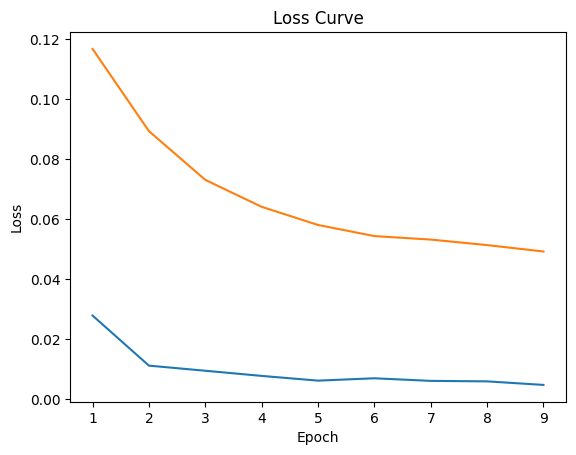

In [14]:
import pandas as pd
results = pd.DataFrame(results)
# Generate loss curve
plt.plot(results['epoch'], results['train_loss_bpr'], label='train')
plt.plot(results['epoch'], results['test_loss_bpr'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

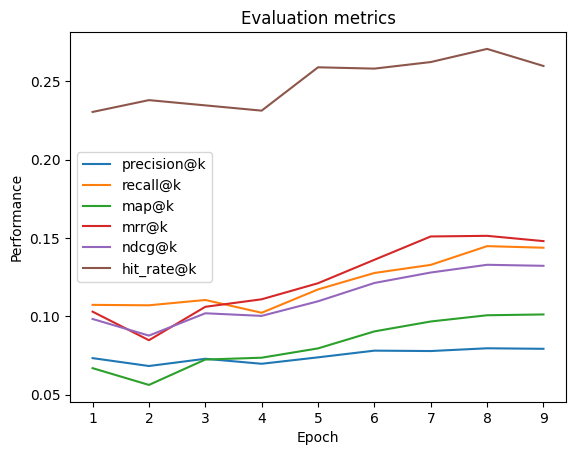

In [15]:
# Generate evaluation metrics plot
plt.plot(results['epoch'], results['precision@k'], label='precision@k')
plt.plot(results['epoch'], results['recall@k'], label='recall@k')
plt.plot(results['epoch'], results['map@k'], label='map@k')
plt.plot(results['epoch'], results['mrr@k'], label='mrr@k')
plt.plot(results['epoch'], results['ndcg@k'], label='ndcg@k')
plt.plot(results['epoch'], results['hit_rate@k'], label='hit_rate@k')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Evaluation metrics')
plt.legend()
plt.show()

In [ ]:
author_sid = '170c9492a9a50fb8a99c45b8cbbf6f55'

model.recommend(x=data.x,
                edge_index=data.train_pos_edge_index,
                author_sid=author_sid,
                k=num_recommendations)